In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/wod_fortime_median.csv')
print(df.shape)
df.head()

(783, 5)


,date,wod,man_setting,woman_setting,median_record_seconds
0,2025-06-03,For time: 30 deadlifts 20 hang squat cleans 10...,205 lb,145 lb,462.5
1,2025-06-02,"For time: 1,600/2,000-meter row Every 90 secon...",NaN,NaN,797.5
2,2025-05-30,Elizabeth 21-15-9 reps for time of: Cleans Rin...,135 lb,95 lb,443.0
3,2025-05-26,Murph For time: Run 1 mile 100 pull-ups 200 pu...,NaN,NaN,2926.0
4,2025-05-23,5 rounds for time of: 15 GHD back extensions 2...,NaN,NaN,820.0


In [3]:
df = df[df['median_record_seconds'] > 240]
df.shape

(753, 5)

In [4]:
import re

wods = df['wod']
settings = df['man_setting'].astype(str)
settings = settings.str.replace(r'(\d+(?:\.\d+)?)[\s\-]?kg', r'\1kg', regex=True)

def convert_kg_to_lb(text):
    def replacer(match):
        kg = float(match.group(1))
        lb = round(kg * 2.2)
        return f'{lb} lb'
    return re.sub(r'(\d+(?:\.\d+)?)kg', replacer, text)

settings = settings.apply(convert_kg_to_lb)

weights = settings.str.findall(r'(\d+(?:\.\d+)?)(?:[\s\-]*lb)')
weights = weights.apply(lambda x: [float(w) for w in x if w])
mean_weights = weights.apply(lambda x: np.mean(x) if x else np.nan)
mean_weights = mean_weights.fillna(0)

df['mean_weight'] = mean_weights
df.head()

,date,wod,man_setting,woman_setting,median_record_seconds,mean_weight
0,2025-06-03,For time: 30 deadlifts 20 hang squat cleans 10...,205 lb,145 lb,462.5,205.0
1,2025-06-02,"For time: 1,600/2,000-meter row Every 90 secon...",NaN,NaN,797.5,0.0
2,2025-05-30,Elizabeth 21-15-9 reps for time of: Cleans Rin...,135 lb,95 lb,443.0,135.0
3,2025-05-26,Murph For time: Run 1 mile 100 pull-ups 200 pu...,NaN,NaN,2926.0,0.0
4,2025-05-23,5 rounds for time of: 15 GHD back extensions 2...,NaN,NaN,820.0,0.0


1. TF-IDF + mean weight + median record

In [40]:
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import math


def make_vector(wods, weights, record, alpha=1.0):
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 1),
        max_features=None,
        # stop_words='english'
    )
    X = vectorizer.fit_transform(wods)

    scaler = StandardScaler()
    weights_scaled = scaler.fit_transform(weights.values.reshape(-1, 1)) * alpha
    record_scaled = scaler.fit_transform(record.values.reshape(-1, 1))
    X = scipy.sparse.hstack([X, weights_scaled, record_scaled])

    return X, vectorizer

def visualize_silhouette(cluster_lists, X_features):

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    if n_cols == 1:
        axs = [axs]

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, X_features.shape[0] + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        return cluster_labels

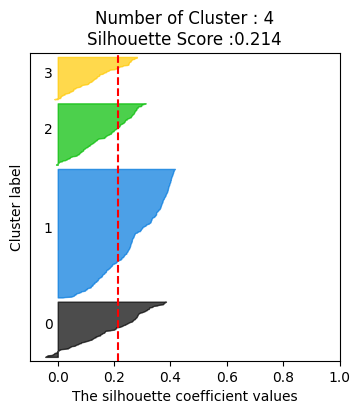

In [41]:
X, vectorizer = make_vector(df['wod'], df['mean_weight'], df['median_record_seconds'])
df['cluster'] = visualize_silhouette([4], X)

In [43]:
print(df['cluster'].value_counts().sort_index())

cluster_examples = (
    df.groupby('cluster')
    .apply(lambda g: g[['wod', 'mean_weight', 'median_record_seconds', 'cluster']].head(5))
    .reset_index(drop=True)
)

cluster_examples['median_record_seconds'] /= 60

display(cluster_examples)

cluster
0    145
1    336
2    161
3    111
Name: count, dtype: int64


,wod,mean_weight,median_record_seconds,cluster
0,"Murph For time: Run 1 mile 100 pull-ups 200 push-ups 300 air squats Run 1 mile Partition the pull-ups, push-ups, and squats as needed. If you’ve got a 14/20-lb vest or body armor, wear it.",0.0,48.766667,0
1,"For time: Run 5,000 meters",0.0,25.050000,0
2,"For time: 2,400-meter run 50 hand-release push-ups 2,400-meter run",0.0,28.416667,0
3,3 rounds for time of: 200-meter dumbbell farmers carry 40 GHD hip extensions 40-calorie row,50.0,23.533333,0
4,"For time: 1,000-meter row 30 dumbbell thrusters 20 pull-ups 5 legless rope climbs to 15 feet 1,000-meter row 5 legless rope climbs to 15 feet 20 pull-ups 30 dumbbell thrusters 1,000-meter row",35.0,23.683333,0
5,"For time: 1,600/2,000-meter row Every 90 seconds, including the start, perform 3 wall walks until you complete the row.",0.0,13.291667,1
6,5 rounds for time of: 15 GHD back extensions 25 AbMat sit-ups 50 double-unders,0.0,13.666667,1
7,For time: 30 toes-to-bars 20 lateral burpees over the dumbbell 10 alternating dumbbell snatches 24 toes-to-bars 16 lateral burpees over the dumbbell 8 alternating dumbbell snatches 18 toes-to-bars 12 lateral burpees over the dumbbell 6 alternating dumbbell snatches,75.0,11.358333,1
8,For time: 20 dumbbell box step-overs 40 GHD sit-ups 60-calorie Echo bike 40 GHD sit-ups 20 dumbbell box step-overs,50.0,12.650000,1
9,"9 rounds for time of: 3 strict muscle-ups 3 kettlebell snatches, right arm 3 kettlebell snatches, left arm",53.0,11.075000,1


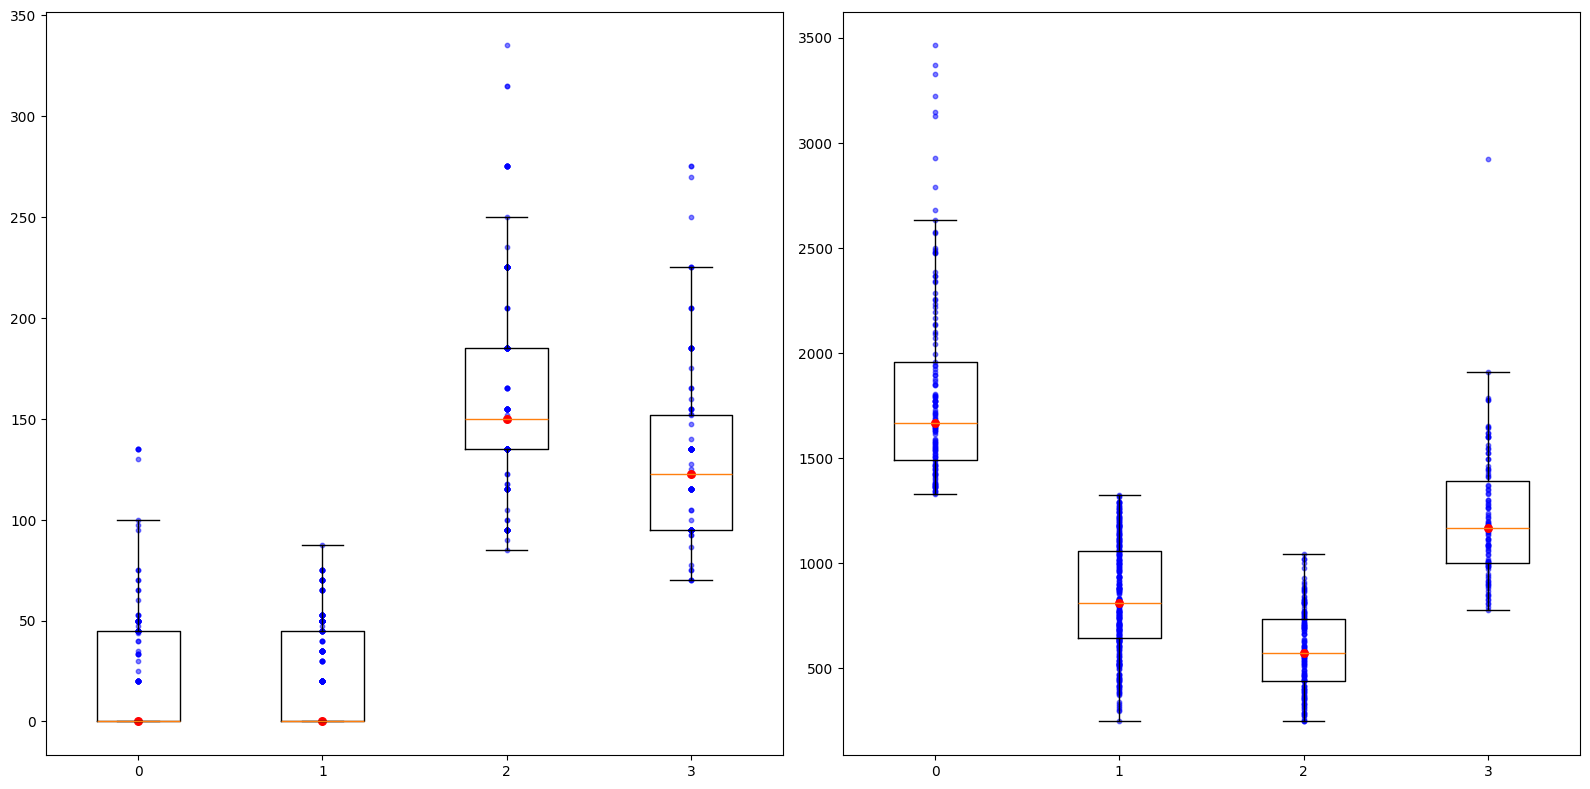

In [44]:
clst = 4

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

weights = [df[df['cluster'] == i]['mean_weight'].values for i in range(0,clst)]
records = [df[df['cluster'] == i]['median_record_seconds'].values for i in range(0,clst)]

data = [weights, records]

for k, d in enumerate(data):
    axs[k].boxplot(d, labels=range(0,clst), showfliers=False)

    for i, values in enumerate(d, 1):  # 1부터 시작 (boxplot 위치는 1-indexed)
        y = values
        x = [i] * len(y)  # 같은 위치에 여러 점
        axs[k].scatter(x, y, alpha=0.5, color='blue', s=10)
        axs[k].scatter(i, np.median(values), color='red', s=30)

plt.tight_layout()
plt.show()

0: 지구력, 장시간   
1: 유산소, 메트콘  
2: 고중량, 파워   
3: 볼륨, 근력

In [45]:
df['silhouette']=silhouette_samples(X, df['cluster'])
print(df[df['silhouette'] < 0].shape)
df[df['silhouette'] < 0].sort_values('silhouette', ascending=False).head(10)

(20, 8)


,date,wod,man_setting,woman_setting,median_record_seconds,mean_weight,cluster,silhouette
246,2023-10-13,10-9-8-7-6-5-4-3-2-1 reps for time of: Deadlift Front squats,"315-lb deadlifts, 225-lb front squats","225-lb deadlifts, 165-lb front squats",1240.0,270.0,3,-0.000863
758,2019-04-27,5 rounds for time of: 7 left-arm dumbbell rows 7 right-arm dumbbell rows 21 dumbbell bench presses 500-m row,50-lb. dumbbells,35-lb. dumbbells,1376.5,50.0,0,-0.002075
658,2020-05-15,"3 rounds for time: 12 left-hand Turkish get-ups 12 right-hand Turkish get-ups 3 legless rope climbs, 15-ft. rope",50-lb. dumbbell,35-lb. dumbbell,1364.0,50.0,0,-0.002899
553,2021-04-29,Manion 7 rounds for time of: Run 400 meters 29 back squats,135 lb.,95 lb.,2089.0,135.0,0,-0.003501
365,2022-10-10,5 rounds for time of: 24 deadlifts 18 hang power cleans 12 push jerks,95 lb,65 lb,784.0,95.0,2,-0.005080
606,2020-11-20,"For time: 45 kettlebell swings 400-m run 35 kettlebell swings 800-m run 25 kettlebell swings 1,200-m run 15 kettlebell swings",32 kg,24 kg,1184.0,70.0,3,-0.005778
14,2025-04-26,3 rounds for time of: 7 wall walks 14 front squats 21 kettlebell swings,"165-lb barbell, 70-lb kettlebell","115-lb barbell, 53-lb kettlebell",825.0,117.5,2,-0.006085
648,2020-06-29,10 rounds for time of: 3 weighted pull-ups 5 strict pull-ups 7 kipping pull-ups,45-lb,30-lb,1370.0,45.0,0,-0.006841
39,2025-02-24,"3 rounds for time of: 1,750/2,500-meter Echo bike 30 wall-ball shots 30 knees-to-elbows",20-lb medicine ball to a 10-foot target,14-lb medicine ball to a 9-foot target,1364.0,20.0,0,-0.011938
541,2021-05-24,For time: 50 dumbbell snatches 5 rope climbs 40 dumbbell snatches 4 rope climbs 30 dumbbell snatches 3 rope climbs 20 dumbbell snatches 2 rope climbs 10 dumbbell snatches 1 rope climb,"70-lb. DB, 15-ft. rope","45-lb. DB, 15-ft. rope",1186.5,70.0,3,-0.012195


2. BERT + mean weight + median record

In [23]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [24]:
model.to('cuda')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [25]:
input = tokenizer(df['wod'].tolist(), padding=True, truncation=True, return_tensors='pt')

input = {key: val.to(model.device) for key, val in input.items()}

model.eval()
with torch.no_grad():
    outputs = model(**input)

cls = outputs.last_hidden_state[:, 0, :]

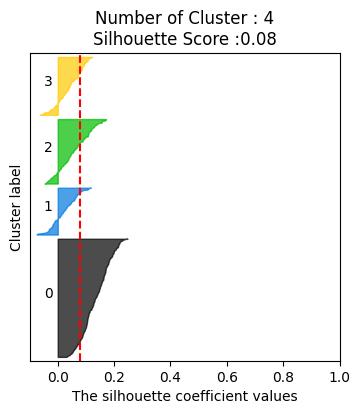

In [42]:
cls_np = cls.cpu().numpy()

scaler = StandardScaler()
weights_scaled = scaler.fit_transform(df['mean_weight'].values.reshape(-1, 1))
records_scaled = scaler.fit_transform(df['median_record_seconds'].values.reshape(-1, 1))

bert_X = np.hstack([cls_np, weights_scaled, records_scaled])

df['bert_cluster'] = visualize_silhouette([4], bert_X)

In [43]:
print(df['bert_cluster'].value_counts().sort_index())

cluster_examples = (
    df.groupby('bert_cluster')
    .apply(lambda g: g[['wod', 'mean_weight', 'median_record_seconds', 'bert_cluster']].head(5))
    .reset_index(drop=True)
)

cluster_examples['median_record_seconds'] /= 60

display(cluster_examples)

bert_cluster
0    309
1    123
2    169
3    152
Name: count, dtype: int64


,wod,mean_weight,median_record_seconds,bert_cluster
0,4 rounds for time of: 50 air squats 15 shoulder-to-overheads,155.0,13.358333,0
1,"9 rounds for time of: 3 strict muscle-ups 3 kettlebell snatches, right arm 3 kettlebell snatches, left arm",53.0,11.075000,0
2,3 rounds for time of: 12 dumbbell squat cleans 24 toes-to-bars 400-meter run,50.0,16.366667,0
3,3 rounds for time of: 7 wall walks 14 front squats 21 kettlebell swings,117.5,13.750000,0
4,"For time: 1,000-meter run 30 handstand push-ups 1,000-meter row",0.0,13.000000,0
5,"Murph For time: Run 1 mile 100 pull-ups 200 push-ups 300 air squats Run 1 mile Partition the pull-ups, push-ups, and squats as needed. If you’ve got a 14/20-lb vest or body armor, wear it.",0.0,48.766667,1
6,For time: 30 toes-to-bars 20 lateral burpees over the dumbbell 10 alternating dumbbell snatches 24 toes-to-bars 16 lateral burpees over the dumbbell 8 alternating dumbbell snatches 18 toes-to-bars 12 lateral burpees over the dumbbell 6 alternating dumbbell snatches,75.0,11.358333,1
7,For time: 40 pull-ups 40 burpees 20 power snatches Rest 3 minutes For time: 30 pull-ups 30 burpees 15 power snatches Rest 2 minutes For time: 20 pull-ups 20 burpees 10 power snatches,115.0,22.783333,1
8,For time: 50 box jumps 40-calorie Echo bike 30 deadlifts 40-calorie Echo bike 50 box jumps,225.0,15.500000,1
9,For time: 150 double-unders 45-calorie row 15 bar muscle-ups 120 double-unders 36-calorie row 12 bar muscle-ups 90 double-unders 27-calorie row 9 bar muscle-ups,0.0,21.033333,1


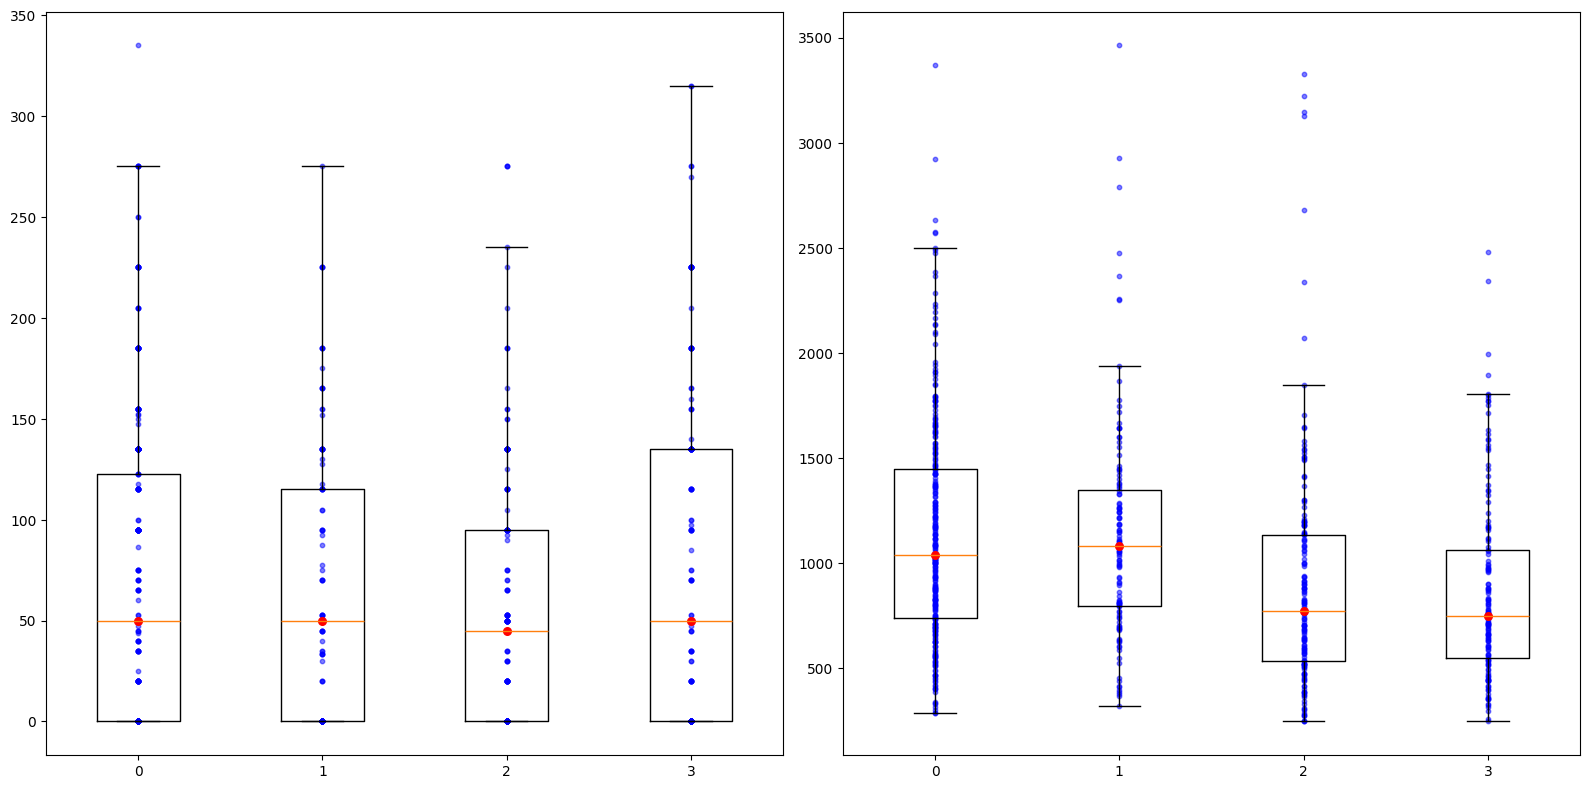

In [44]:
clst = 4

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

weights = [df[df['bert_cluster'] == i]['mean_weight'].values for i in range(0,clst)]
records = [df[df['bert_cluster'] == i]['median_record_seconds'].values for i in range(0,clst)]

data = [weights, records]

for k, d in enumerate(data):
    axs[k].boxplot(d, labels=range(0,clst), showfliers=False)

    for i, values in enumerate(d, 1):  # 1부터 시작 (boxplot 위치는 1-indexed)
        y = values
        x = [i] * len(y)  # 같은 위치에 여러 점
        axs[k].scatter(x, y, alpha=0.5, color='blue', s=10)
        axs[k].scatter(i, np.median(values), color='red', s=30)

plt.tight_layout()
plt.show()

3. GMM

In [46]:
from sklearn.mixture import GaussianMixture

def gmm_visualize_silhouette(cluster_lists, X_features):

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    if n_cols == 1:
        axs = [axs]

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # GaussianMixture 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = GaussianMixture(n_components = n_cluster, max_iter=500, random_state=0, init_params='kmeans')
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, X_features.shape[0] + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        return cluster_labels

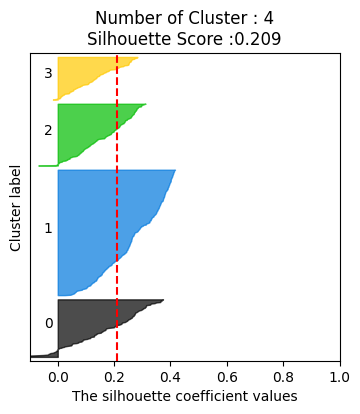

In [47]:
df['gmm_cluster'] = gmm_visualize_silhouette([4], X.toarray())

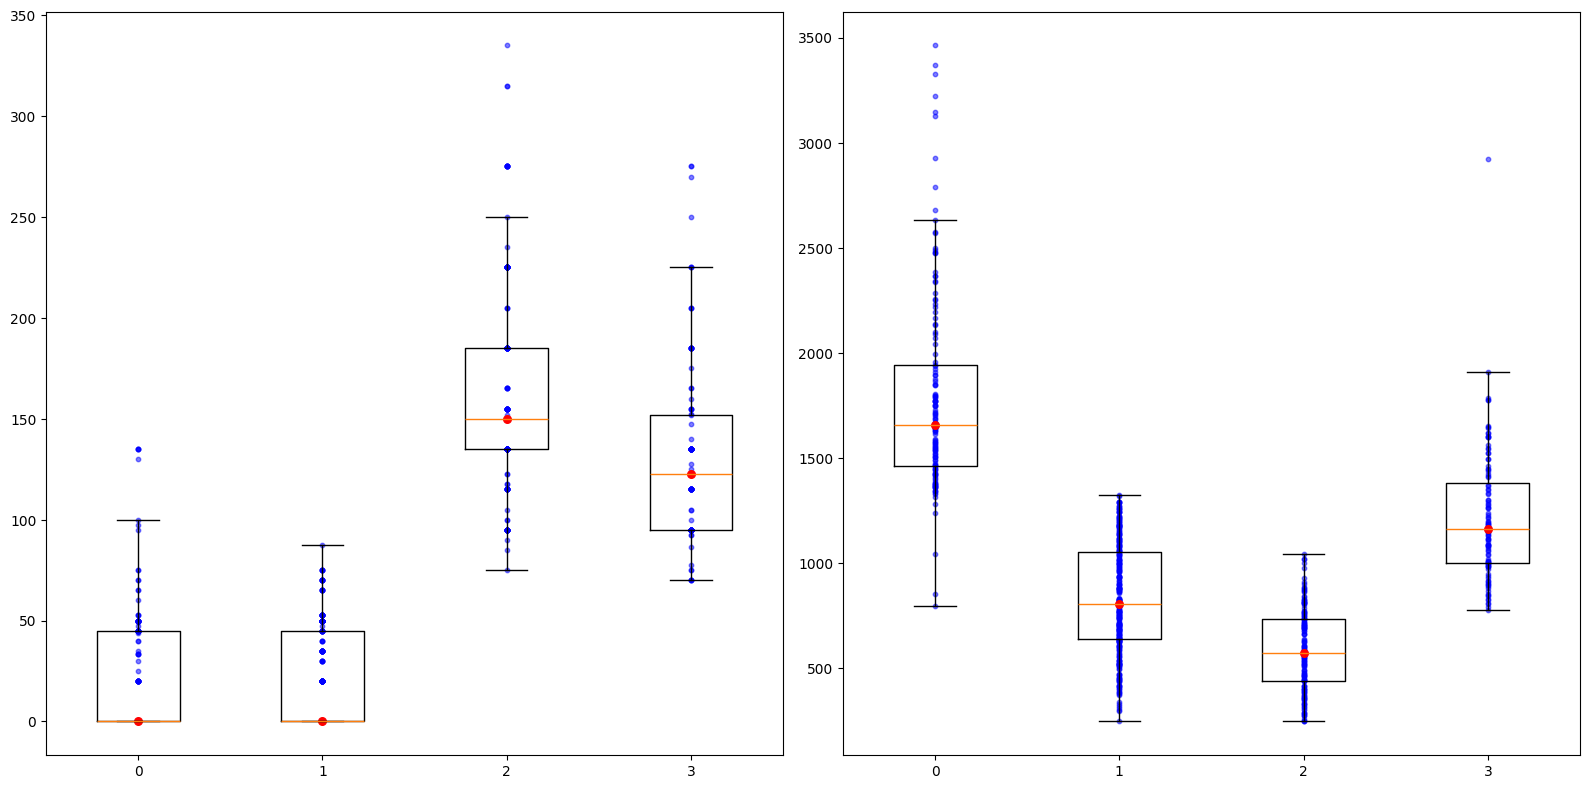

In [48]:
clst = 4

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

weights = [df[df['gmm_cluster'] == i]['mean_weight'].values for i in range(0,clst)]
records = [df[df['gmm_cluster'] == i]['median_record_seconds'].values for i in range(0,clst)]

data = [weights, records]

for k, d in enumerate(data):
    axs[k].boxplot(d, labels=range(0,clst), showfliers=False)

    for i, values in enumerate(d, 1):  # 1부터 시작 (boxplot 위치는 1-indexed)
        y = values
        x = [i] * len(y)  # 같은 위치에 여러 점
        axs[k].scatter(x, y, alpha=0.5, color='blue', s=10)
        axs[k].scatter(i, np.median(values), color='red', s=30)

plt.tight_layout()
plt.show()

KMeans로 생성한 label로 KNN 학습

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

wod_train, wod_test, weight_train, weight_test, y_train, y_test = train_test_split(df['wod'], df['mean_weight'], df['cluster'], test_size=0.2, random_state=42)

vec = TfidfVectorizer(ngram_range=(1, 1), max_features=None)
vec_train = vec.fit_transform(wod_train)
vec_test = vec.transform(wod_test)

scaler = StandardScaler()
weight_train = scaler.fit_transform(weight_train.values.reshape(-1, 1))
weight_test = scaler.transform(weight_test.values.reshape(-1, 1))

X_train = scipy.sparse.hstack([vec_train, weight_train])
X_test = scipy.sparse.hstack([vec_test, weight_test])

KNN = KNeighborsClassifier(n_neighbors=18, weights='distance')
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7549668874172185


In [83]:
print(y_test.values)
print(y_pred)
display(df.loc[y_test.index])

[3 2 1 2 2 2 0 0 0 3 0 3 1 2 1 3 0 1 3 2 0 2 1 1 2 0 2 2 2 1 2 0 1 2 2 3 1
 0 3 0 1 2 1 1 2 3 1 0 1 1 1 3 0 2 1 1 1 1 0 2 0 1 1 3 2 0 1 1 2 1 1 0 1 2
 0 1 1 0 3 2 1 3 1 1 1 0 1 2 2 2 1 1 0 3 3 1 1 1 2 2 3 1 1 1 1 1 2 0 1 0 0
 0 1 1 2 1 1 1 1 1 1 0 1 1 3 2 3 1 0 2 0 1 1 0 1 0 1 1 0 0 0 1 3 2 1 1 1 1
 1 1 0]
[2 2 1 2 3 2 1 1 1 3 0 2 1 3 1 2 0 1 2 3 0 2 1 1 2 0 2 2 3 1 2 1 1 2 2 3 1
 0 2 1 1 2 1 1 2 3 1 0 1 1 1 3 0 2 1 1 1 1 1 2 0 1 1 2 2 1 1 1 2 1 1 1 1 2
 0 1 3 0 2 3 1 3 1 1 1 1 1 2 2 2 1 1 0 2 2 1 1 1 2 2 3 0 1 1 1 3 2 1 1 1 0
 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 3 1 0 2 1 1 1 0 1 3 1 1 0 1 1 1 2 2 1 1 1 1
 1 1 1]


,date,wod,man_setting,woman_setting,median_record_seconds,mean_weight,cluster,silhouette,gmm_cluster
745,2019-06-24,For time: 10 L chest-to-bar pull-ups 10 shoulder presses 15 L pull-ups 20 push presses 20 strict pull-ups 30 push jerks 25 kipping pull-ups,105 lb.,70 lb.,812.0,105.0,3,0.014163,3
677,2020-02-19,Elizabeth 21-15-9 reps for time of: Cleans Ring dips,135 lb,95 lb,379.0,135.0,2,0.273339,2
389,2022-07-29,21-18-15-12-9-6-3 reps for time of: Box jumps Ring push-ups,30-in box,24-in box,682.5,0.0,1,0.407874,1
78,2024-11-09,21-15-9 reps for time of: Power snatches Strict handstand push-ups,135 lb,95 lb,709.0,135.0,2,0.131355,2
219,2023-12-18,5 rounds for time: 15 push jerks 12 chest-to-bar pull-ups 9 sumo deadlift high pulls,95 lb,65 lb,749.0,95.0,2,0.000536,2
...,...,...,...,...,...,...,...,...,...
348,2022-12-05,Ellen 3 rounds for time of: 20 burpees 21 dumbbell snatches 12 dumbbell thrusters,50-lb. DBs,35-lb. DBs,765.0,50.0,1,0.257289,1
91,2024-10-14,"For time: 1,000-meter row 800-meter run 500-meter row 400-meter run 250-meter row 200-meter run",NaN,NaN,934.0,0.0,1,0.333058,1
373,2022-09-18,6-5-4-3-2-1 reps for time of: Strict muscle-ups 1.5x bodyweight front squats,NaN,NaN,752.0,0.0,1,0.395040,1
678,2020-02-14,4 rounds for time of: 400-m run 200-m farmers carry,50-lb. DBs,35-lb. DBs,1138.0,50.0,1,0.131430,1


In [84]:
misclassified_indices = y_test[y_test.values != y_pred].index

print("Misclassified examples:")
display(df.loc[misclassified_indices])
print(df.loc[misclassified_indices]['cluster'].value_counts())

Misclassified examples:


,date,wod,man_setting,woman_setting,median_record_seconds,mean_weight,cluster,silhouette,gmm_cluster
745,2019-06-24,For time: 10 L chest-to-bar pull-ups 10 shoulder presses 15 L pull-ups 20 push presses 20 strict pull-ups 30 push jerks 25 kipping pull-ups,105 lb.,70 lb.,812.0,105.0,3,0.014163,3
219,2023-12-18,5 rounds for time: 15 push jerks 12 chest-to-bar pull-ups 9 sumo deadlift high pulls,95 lb,65 lb,749.0,95.0,2,0.000536,2
593,2021-01-07,Lyla 10-9-8-7-6-5-4-3-2-1 reps for time of: Muscle-ups Bodyweight clean and jerks,NaN,NaN,1589.0,0.0,0,0.167497,0
259,2023-08-28,"For time: Run 1 mile 2,000-meter Echo Bike 1,000-meter row Run 1 mile",NaN,NaN,1491.0,0.0,0,0.113254,0
324,2023-02-13,3 rounds for time of: 50 GHD sit-ups 25 strict handstand push-ups,NaN,NaN,1531.0,0.0,0,0.134558,0
714,2019-09-16,12-9-6-3 reps for time of: Clean and jerks Bar muscle-ups,185 lb.,125 lb.,1105.0,185.0,3,0.055517,3
748,2019-06-19,"3 rounds for time of: 15 thrusters 3 15-ft. rope climbs, legless ascent and descent",155 lb.,105 lb.,867.0,155.0,2,0.028465,2
103,2024-09-16,20 rounds for time of: 2 power cleans 3 box jumps 4 chest-to-bar pull-ups,185 lb and 24-inch box,125 lb and 20-inch box,1177.0,185.0,3,0.112470,3
99,2024-09-28,7 rounds for time of: 7 hang cleans 7 front squats 7 shoulder-to-overheads 7 bar-facing burpees,115 lb,75 lb,1000.0,115.0,3,0.124554,3
203,2024-01-27,For time: 12 squat clean thrusters Run 400 meters 9 squat clean thrusters Run 400 meters 6 squat clean thrusters Run 400 meters,115 lb,75 lb,585.0,115.0,2,0.125091,2


cluster
0    18
3    11
2     5
1     3
Name: count, dtype: int64


In [93]:
test_text = ['For time: 800-meter run 40 wall-ball shots 400-meter run 30 wall-ball shots 200-meter run 20 wall-ball shots',
             '3 rounds for time of: 100 double-unders 15 deadlifts 15 bar-facing burpees',
             'For time: 100 burpee pull-ups',
             '5-10-15-20-15-10-5 Toes To Bar Dumbbell Box Step Overs',
             '50 Power Cleans Every 1:00 Including 0:00 3 Burpee Pull-ups',
             'run 10km',
             '5 Sets : 1:00 Row (9 RPE) Rest 1:00 Between Sets 10 Sets : :30 Row (9 RPE) Rest :30 Between Sets',
             '3 rounds for time of: 15 Power Snatch 15 Lateral Burpees']

test_w = [[20.],
        [225.],
        [0.],
        [50.],
        [115.],
        [0.],
        [0.],
        [115.]]

temp = vec.transform(test_text)
temp = scipy.sparse.hstack([temp, scaler.transform(test_w)])
print(KNN.predict(temp))

[1 2 1 1 3 1 1 3]


In [94]:
wod_cluster = KNeighborsClassifier(n_neighbors=8, weights='distance')

wod_cluster_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, stop_words='english')
vec = wod_cluster_vectorizer.fit_transform(df['wod'])

wod_cluster_weight_scaler = StandardScaler()
weight_scaled = wod_cluster_weight_scaler.fit_transform(df['mean_weight'].values.reshape(-1, 1))

wod_cluster_X = scipy.sparse.hstack([vec, weight_scaled])

wod_cluster.fit(wod_cluster_X, df['cluster'])

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [95]:
import pickle

with open("/content/wod_cluster.pkl", "wb") as fw:
    pickle.dump(wod_cluster, fw)

with open("/content/wod_cluster_vectorizer.pkl", "wb") as fw:
    pickle.dump(wod_cluster_vectorizer, fw)

with open("/content/wod_cluster_weight_scaler.pkl", "wb") as fw:
    pickle.dump(wod_cluster_weight_scaler, fw)

In [96]:
with open("/content/wod_cluster.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("/content/wod_cluster_vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)

with open("/content/wod_cluster_weight_scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

In [97]:
t = loaded_vectorizer.transform(test_text)
t = scipy.sparse.hstack([t, loaded_scaler.transform(test_w)])
print(loaded_model.predict(t))

[1 2 1 1 2 0 1 2]


In [98]:
df.to_csv('/content/wod_fortime_median_cluster.csv', index=False)